# Imports

In [1]:
import os
import sys
import pandas as pd

In [2]:
# If you intend to run the notebook from its original folder, example/start, you can keep the following line.
# Otherwise, you need to append the path to the leaspy folder
sys.path.append(os.path.join(os.getcwd(), '..', '..'))

from leaspy.main import Leaspy
from leaspy.inputs.data.data import Data
from leaspy.inputs.settings.algorithm_settings import AlgorithmSettings
from leaspy.utils.output.visualization.plotter import Plotter

# Step 1. Inputs

### - Data

To load the data, you have two options : either loading a csv file, or, loading a dataframe. The second option might be of interest if you have csv file from which you want to subselect a part of the data or of the features, and, passing it to Leaspy. The corresponding command is
`data = Data.from_dataframe(df)`

The input format is identical for both : one line per measurement, resulting in multiple lines per subject, with one column named 'ID' for the subject index, and one column name 'TIME' for the time at which the measurement is done (it is usually the age of the subject at the given measurement)

In [3]:
data = Data.from_csv_file(os.path.join('_inputs', 'data.csv'))

### - Parameters

To run any algorithm, you need to specify its settings. To ease Leaspy's usage for beginners, we specified default values for each algorithm. Therefore, the name of the algorithm used is enough to run it. However, you can load the algorithm settings you want by using `settings.load_json(path/to_json)`. Some example of such json are given in the `_inputs` folder. 
Nevertheless, you can choose to change only some parameters with optional arguments, such as the `n_iter` example bellow. The list of these optional arguments is actually the one in the previous json files.

Finally, the function `set_logs` allows you to save graphical logs of the run. The folder you set must exist prior to running the algorithm. However, if it already contains elements (if you have already run the algorith for instance), it will kindly ask you if you want to erase the previous logs. 

Be careful that you have the `_outputs/logs/fit` folder. Otherwise, you can create them with `os.mkdir('_outputs')`, `os.mkdir(os.path.join('_outputs', 'logs'))` and `os.mkdir(os.path.join('_outputs', 'logs', 'fit'))`

In [11]:
algo_settings = AlgorithmSettings('mcmc_saem', n_iter=3)
algo_settings.set_logs('_outputs/logs/fit') 

# Step 2. Fit model

Now that you have your data and your settings, you can run the model. You first need to choose the type of progression shape you want to give to your data. You can either choose logistic or linear (soon exponential) with the possibility to enforce a parallelism between the features. The dedicated names are  :

`logistic`, `logistic_parallel`, `linear` and `linear_parallel`.

While the non parallel version might better fit your data as it has additional degrees of freedom, the parallel version gives you a clearer understanding of the ordering of your features.

Note : the model might rely on hyperparameters that you can define as shown below. There are optional.

In [12]:
leaspy = Leaspy("logistic_parallel")
leaspy.model.load_hyperparameters({'source_dimension': 2}) # Optional

In [13]:
leaspy.fit(data, algorithm_settings=algo_settings)

=== ALGO ===
Instance of MCMC_SAEM (tensor) algo 
Iteration 0
=Samplers 
    g rate : 0.0%, std: 0.004999999888241291
    deltas rate : 1.3333333656191826%, std: 0.004999999888241291
    tau rate : 3.5322580486536026%, std: 0.1000000461935997
    xi rate : 2.564516104757786%, std: 0.1000000461935997
    sources rate : 3.6935482174158096%, std: 0.1000000461935997
    betas rate : 1.9999999552965164%, std: 0.004999999422580004

=== MODEL ===
g : 1.0
tau_mean : 69.91848754882812
tau_std : 1.9185583591461182
xi_mean : -3.0279362201690674
xi_std : 0.10914602130651474
sources_mean : 0.0
sources_std : 1.0
noise_std : 0.26629695296287537
deltas : tensor([ 0.0000, -0.0046,  0.0000])
betas : tensor([[-0.0048,  0.0000],
        [-0.0013,  0.0000],
        [-0.0014,  0.0000]])

Duration since last print : 0.0s
The standard deviation of the noise at the end of the calibration is 0.2627


There are many reasons why one might want to save the output parameters of the model, allowed with the following commands : `leaspy.save(path/to/output/folder/parameters.json)` which creates a json file. You can later on load these parameters directly with `leaspy = Leaspy.load(path/to/output/folder/parameters.json`.

In [14]:
leaspy.save("_outputs/model_parameters.json") # optional

Once fitted, you might want to produce your first result by checking what the estimated long-term trajecory is for your features and data. This is allower with a visualization toolbox as in the example bellow.

Note that the `_output/plots` argument is optional and it basically gives you the opportynity to save the plots where you want, by adding then the `save_as` argument to the plot functions.

 Again, you might need to create the folder with `os.mkdir('_outputs/plots')`

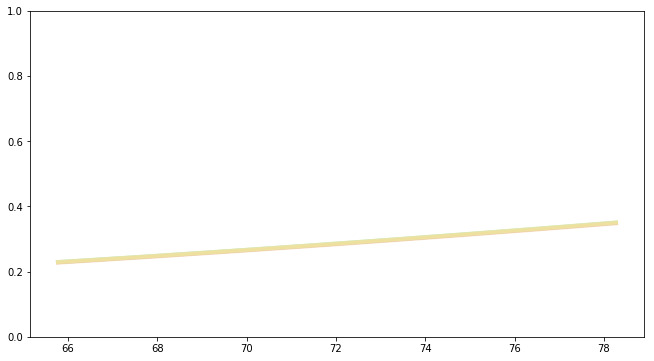

In [16]:
plotter = Plotter('_outputs/plots') 
plotter.plot_mean_trajectory(leaspy.model, labels=['memory', 'concentration', 'praxis', 'language'], save_as="mean_plot.pdf")


# Step 3. Personalize the model to individual data

### - Personalization

The personalization allows to modify the group-average trajectory to individual observations. This personalization outputs individual parameters that describe how the group-average trajectory has been modifies to git individual data. These parameters are : 
- $\alpha_i = \exp(\xi_i)$ : the acceleration factor, that modulates the speed of progression
- $\tau_i$ : the time shift which delays (earlier or later) the progression in a given number of years
- $w_i$ : the space-shift (which is a function of the sources $(s_{ij})_j$) which might, for a given individual, change the ordering of the conversion of the different features, compared to the mean trajectory.

The personalization is based on some settings for which you can load default values : 

In [17]:
settings = AlgorithmSettings('scipy_minimize')

In [18]:
results = leaspy.personalize(data, settings)

Beginning personalization : std error of the model is 0.26271721720695496
0.239343
The standard deviation of the noise at the end of the personalization is of 0.2513
Personalization scipy_minimize took : 0.022938384056091308s


The `results` corresponds to the data at head, with the individual parameters. This will be used to draw the next analysis, such as the reconstruction of the individual trajectory, as plotted here : 

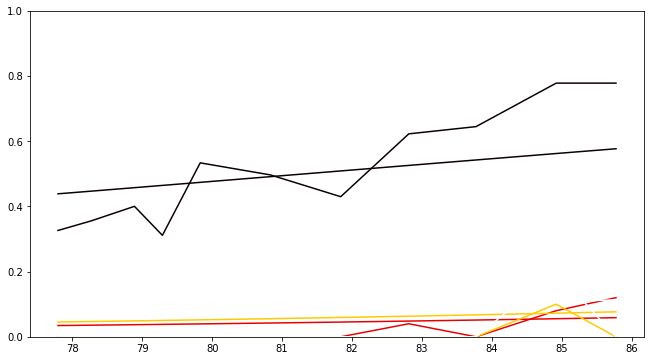

In [12]:
plotter.plot_patient_trajectory(leaspy.model, results, [ '142'], save_as="plot_reconstruction.pdf")

### - Analysis

Further analysis might be undertaken to see how the individual parameters, that modulate the progression of the disease progression, are related to some cofactors. First, one need to load the cofactors : 

In [19]:
df = pd.read_csv(os.path.join(os.getcwd(), '_inputs', 'cofactors.csv'), dtype={'RID': str}).set_index('RID')
data.load_cofactors(df, cofactors=["APOE4", "PTGENDER", "PTMARRY"])

/usr/local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (18,19,20,98,99,100) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


The two next commands shows the distribution of $\xi_i$ ($\alpha_i = \exp(\xi_i)$) among the whole population, and then within some subpopulation, here labeled with their genomic APOE4 status.

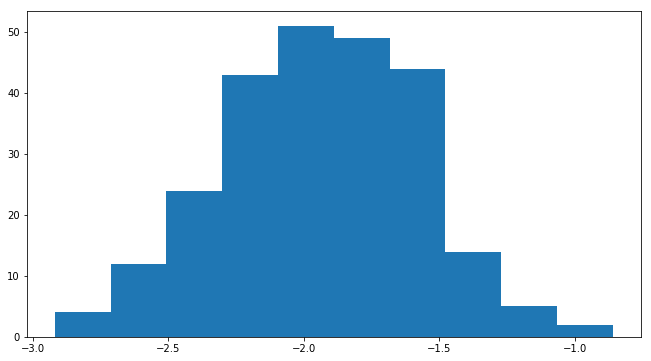

In [15]:
plotter.plot_distribution(results, parameter="xi")

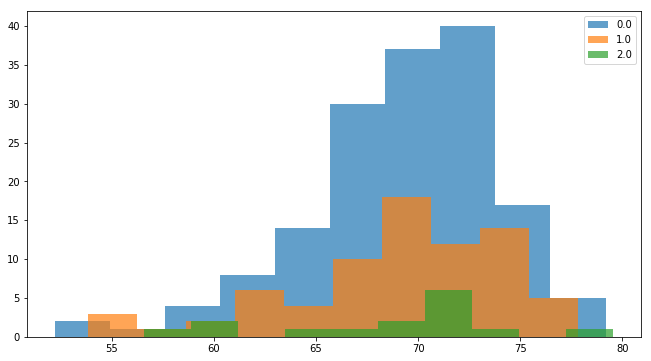

In [16]:
plotter.plot_distribution(results, parameter="tau", cofactor="APOE4")

This analysis helps looking at two different parameters at a time, here $\xi_i$ and $\tau_i$, where each dot is a patient, that one can color with a cofactor.

No handles with labels found to put in legend.


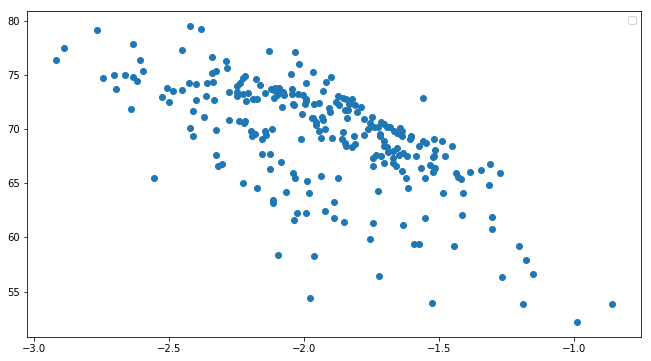

In [17]:
plotter.plot_correlation(results, parameter_1='xi', parameter_2='tau')

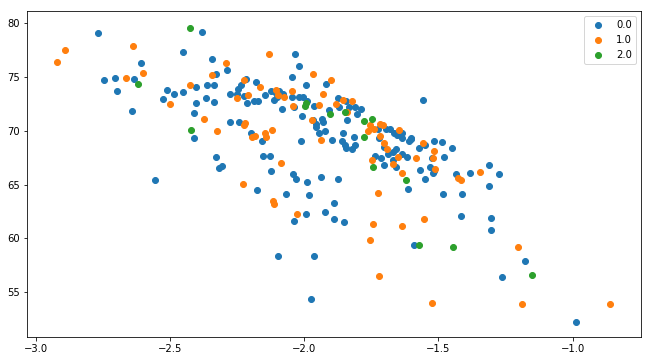

In [18]:
plotter.plot_correlation(results, parameter_1='xi', parameter_2='tau', cofactor='APOE4')

As the algorithm essentially reparametrize each individual timeline towards the group-average, it is possible to see how it has been done. Here, the individual trajectories are projected onto the mean timeline, and it shows that the average is actually a good recombination of short term observations.

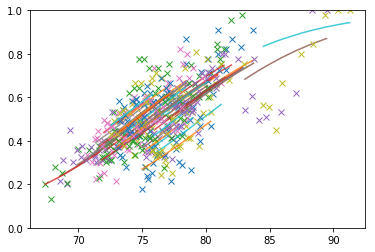

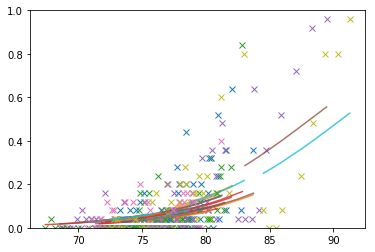

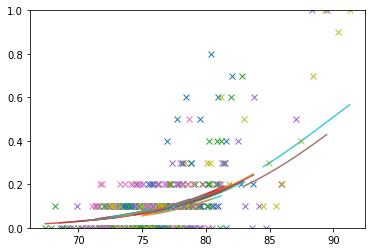

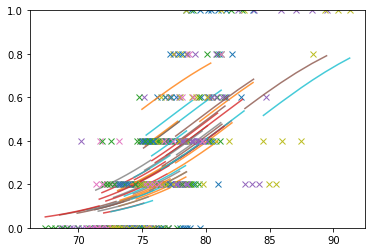

In [19]:
plotter.plot_patients_mapped_on_mean_trajectory(leaspy.model, results)